# Easy network: experimenting with *networkx*

In [12]:
!pip install -r requirements.txt

In [11]:
import networkx as nx
from networkx import MultiGraph
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionStyle 

## Create sample datasets

In [2]:
column_names = ['Name', 'IP', 'Telefon', 'Address']
df_A = pd.DataFrame([['Cla', '95.238.115.7', '12345', 'Bismarckstrasse 5']], columns=column_names)
df_B = pd.DataFrame([['Joh', '95.238.115.7', '23516', 'Unter der Linden 1'], 
                     ['Ale', '94.234.442.4', '24862', 'Bayernallee 12'], 
                     ['Tzd', '98.556.88.9', '12345', 'Hermannplatz 2'],
                     ['Ale', '96.556.88.9', '13445','Bismarckstrasse 5'],
                     ['Bra', '0.156.452.4', '12345', 'Bismarckstrasse 5'],
                     ['Deu', '0.0.452.4', '12345', 'Braunstraße 88'],
                     ['Ale', '95.238.115.7', '41345', 'Arschlochstrasse 00']
                    ], columns=column_names)

## Merge both datasets 
Merge dataset on the columns where the entity of the first dataset could have been in contact each record of the second dataset

In [3]:
A = []
B = []
Channel = []
for _ in column_names[1:]:
    tmp = pd.merge(df_A, df_B,  how='left', on=_)
    if len(tmp)>=1:
        A.extend(tmp['Name_x'])
        B.extend(tmp['Name_y'])
        Channel.extend([_ for i in range(len(tmp))])
        
res = pd.DataFrame({'A': A, 'B':B, 'Channel':Channel})
res

,A,B,Channel
0,Cla,Joh,IP
1,Cla,Ale,IP
2,Cla,Tzd,Telefon
3,Cla,Bra,Telefon
4,Cla,Deu,Telefon
5,Cla,Ale,Address
6,Cla,Bra,Address


## Define a graph (nodes, edges) from `pandas DataFrame`

In [4]:
# define a networkx graph
G = nx.MultiGraph()
G = nx.from_pandas_edgelist(res, 'A', 'B', ['Channel'], create_using=nx.MultiGraph())
pos = nx.spring_layout(G, dim=2)

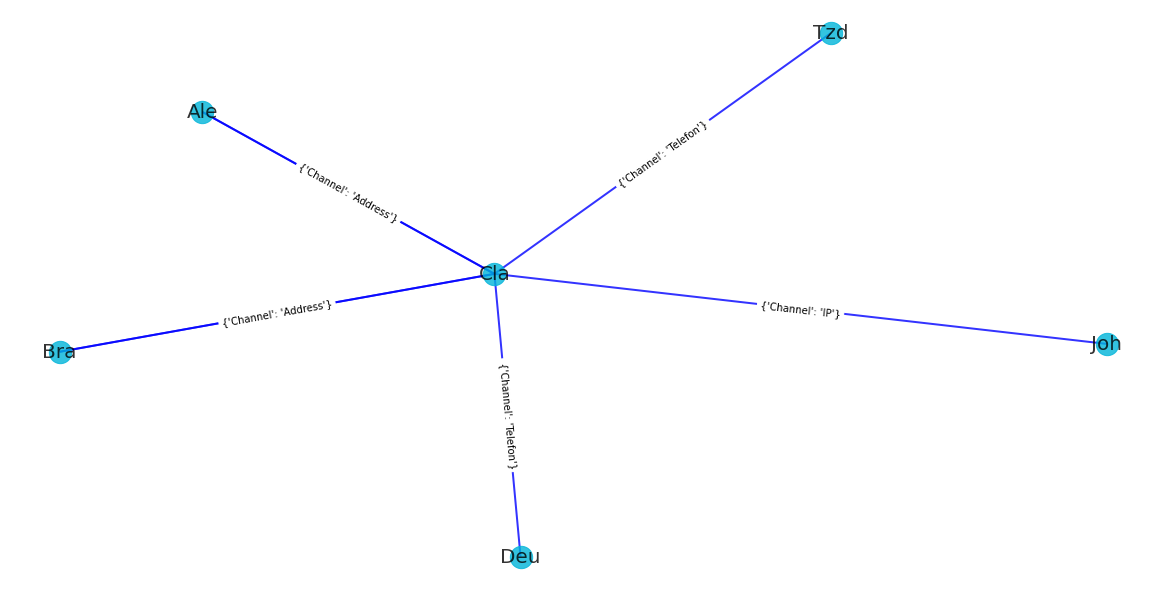

In [5]:
plt.figure(figsize=(16, 8))

nx.draw(G, 
        pos=pos, 
        connectionstyle=ConnectionStyle("Angle", rad=0.2, angleA=90, angleB=0),#'arc3,rad=0.2',
        width=2, 
        alpha=0.8,  
        edge_color='b', 
        with_labels=True, 
        node_color='#00b4d9', 
        node_size=500,
        font_size=20, 
        font_color='black') 

nx.draw_networkx_edge_labels(G, pos)
        
plt.axis('off')
plt.show()

> **Note**: there is a problem with networkx and arch edges. For instance, (Cl, Bra) had two contact channels and in the graph we only see one edge. This is because even if the graph draws both edges, they appear on top of each other. See this [thread](https://stackoverflow.com/questions/15053686/networkx-overlapping-edges-when-visualizing-multigraph). 

## Solution: plot mutiple edges in two steps 

Create a new graph with the same nodes and **unique** way edges

### Create a subset with unique edges

In [6]:
all_edges = list(zip(res.A, res.B))
unique_res = res[['A', 'B']].drop_duplicates()
unique_edges = list(zip(unique_res.A, unique_res.B))
unique_nodes = unique_res['B'].tolist()
unique_nodes.append(unique_res['A'].unique()[0])
#pd.merge(unique_res, res, how='left', on=['A', 'B'])

In [7]:
list(zip(res.A, res.B))

[('Cla', 'Joh'),
 ('Cla', 'Ale'),
 ('Cla', 'Tzd'),
 ('Cla', 'Bra'),
 ('Cla', 'Deu'),
 ('Cla', 'Ale'),
 ('Cla', 'Bra')]

In [8]:
[all_edges[j] for j in range(len(all_edges)) if all_edges[j] in unique_edges]

[('Cla', 'Joh'),
 ('Cla', 'Ale'),
 ('Cla', 'Tzd'),
 ('Cla', 'Bra'),
 ('Cla', 'Deu'),
 ('Cla', 'Ale'),
 ('Cla', 'Bra')]

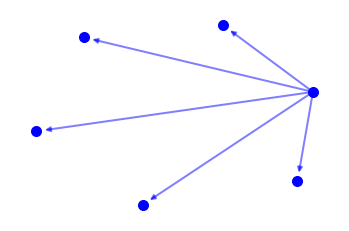

In [9]:
# Create a directed graph
G = nx.DiGraph()
G.add_nodes_from(unique_nodes)
#G = nx.from_pandas_edgelist(unique_edges, 'A', 'B', ['Channel'], create_using=nx.MultiGraph())
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, connectionstyle='arc3, rad = 0.1', node_color = 'b', node_size = 100, alpha = 1)
nx.draw_networkx_edges(G, pos,connectâionstyle='arc3, rad = 0.1', edgelist = unique_edges, width = 2, alpha = 0.5, edge_color='b')
#nx.draw_networkx_edges(G, pos,connectionstyle='arc3, rad = 0.1', edgelist= [(1,0)], width = 1, alpha = 1)
plt.axis('off')
plt.show() 

## Bonus: yet another solution but loosing labels

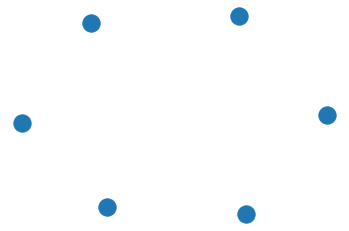

In [10]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, with_labels=True, alpha = 1)
ax = plt.gca()
for e in G.edges:
    ax.annotate("",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="->", color="0.5",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=rrr".replace('rrr',str(2*(e[2]-0.5))
                                ),
                                ),
                )
plt.axis('off')
plt.show()